In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import os
import random
from tqdm import tqdm
import featuretools as ft
from joblib import dump, load
from imblearn.combine import SMOTETomek

from sklearn.preprocessing import MinMaxScaler, minmax_scale, scale, power_transform, quantile_transform, normalize 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, log_loss
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import  QuantileTransformer, PowerTransformer

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

RANDOM_SEED = 777
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    
import warnings
warnings.filterwarnings(
    action='ignore',
)

C:\Users\kurma\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
metadata = pd.read_csv('data/metadata.csv')
sup_metadata = pd.read_csv('data/supplemental_metadata.csv')
train_labels = pd.read_csv('data/train_labels.csv', index_col="sample_id")
val_labels = pd.read_csv('data/val_labels.csv',index_col='sample_id')
targets = pd.read_csv('targets.csv',index_col='sample_id')
submission_format = pd.read_csv('data/submission_format.csv')

In [3]:
train_50 = pd.read_csv('train/train_50.csv',index_col=0,header=[0,1])
val_50 = pd.read_csv('train/val_50.csv',index_col=0,header=[0,1])
test_50 = pd.read_csv('test/test_df_50.csv',index_col=0,header=[0,1])

train_50.sort_index(axis=1,inplace=True)
val_50.sort_index(axis=1,inplace=True)
test_50.sort_index(axis=1,inplace=True)

val_50.index = metadata[metadata.split == 'val'].index

In [4]:
train_set_50 = pd.concat([train_50,val_50],axis=0)
test_set_50 = pd.concat([val_50,test_50],axis=0)
train_set_50.shape, test_set_50.shape

((1059, 4200), (804, 4200))

In [5]:
%%time
test_100 = pd.read_csv('test/test_100.csv',index_col=0,header=[0,1])
train_100 = pd.read_csv('train/train_100.csv',index_col=0,header=[0,1])
val_100 = pd.read_csv('train/val_100.csv',index_col=0,header=[0,1])

val_100.index = metadata[metadata.split == 'val'].sample_id

val_100.sort_index(inplace=True,axis=1)
test_100.sort_index(inplace=True,axis=1)
train_100.sort_index(inplace=True,axis=1)

Wall time: 916 ms


In [6]:
train_set_100 = pd.concat([train_100,val_100],axis=0)
test_set_100 = pd.concat([val_100,test_100],axis=0)
train_set_100.shape, test_set_100.shape

((1059, 1600), (804, 1600))

In [7]:
print(train_100.shape,val_100.shape,test_100.shape)                                                     

(766, 1600) (293, 1600) (511, 1600)


In [8]:
val_idx = metadata[metadata.split == 'val'].index
train_idx = metadata[metadata.split == 'train'].index
test_idx = metadata[metadata.split == 'test'].index

In [9]:
val_id = metadata[metadata.split == 'val'].sample_id
train_id = metadata[metadata.split == 'train'].sample_id
test_id = metadata[metadata.split == 'test'].sample_id

In [10]:
sam_idx = metadata[metadata.instrument_type == 'sam_testbed'].index
com_idx = metadata[metadata.instrument_type == 'commercial'].index

In [11]:
sam_id = metadata[metadata.instrument_type == 'sam_testbed'].sample_id
com_id = metadata[metadata.instrument_type == 'commercial'].sample_id

In [12]:
train_100.iloc[sam_idx[:12],:]

m/z               0                                                 \
temp_bin  (-100, 0]  (0, 100] (100, 200] (1000, 1100] (1100, 1200]   
sample_id                                                            
S0754           0.0  0.000000        0.0          0.0          0.0   
S0755           0.0  0.000000        0.0          0.0          0.0   
S0756           0.0  0.000043        0.0          0.0          0.0   
S0757           0.0  0.000000        0.0          0.0          0.0   
S0758           0.0  0.000000        0.0          0.0          0.0   
S0759           0.0  0.000000        0.0          0.0          0.0   
S0760           0.0  0.000000        0.0          0.0          0.0   
S0761           0.0  0.000000        0.0          0.0          0.0   
S0762           0.0  0.000000        0.0          0.0          0.0   
S0763           0.0  0.000000        0.0          0.0          0.0   
S0764           0.0  0.000000        0.0          0.0          0.0   
S0765           0.0  0.000000        0.0          0.0          0.0   

m/z                                                                     ...  \
temp_bin  (1200, 1300] (1300, 1400] (1400, 1500] (200, 300] (300, 400]  ...   
sample_id                                                               ...   
S0754              0.0          0.0          0.0        0.0        0.0  ...   
S0755              0.0          0.0          0.0        0.0        0.0  ...   
S0756              0.0          0.0          0.0        0.0        0.0  ...   
S0757              0.0          0.0          0.0        0.0        0.0  ...   
S0758              0.0          0.0          0.0        0.0        0.0  ...   
S0759              0.0          0.0          0.0        0.0        0.0  ...   
S0760              0.0          0.0          0.0        0.0        0.0  ...   
S0761              0.0          0.0          0.0        0.0        0.0  ...   
S0762              0.0          0.0          0.0        0.0        0.0  ...   
S0763              0.0          0.0          0.0        0.0        0.0  ...   
S0764              0.0          0.0          0.0        0.0        0.0  ...   
S0765              0.0          0.0          0.0        0.0        0.0  ...   

m/z                 99                                                \
temp_bin  (1300, 1400] (1400, 1500] (200, 300] (300, 400] (400, 500]   
sample_id                                                              
S0754              0.0          0.0   0.000337   0.000281   0.000337   
S0755              0.0          0.0   0.000059   0.000049   0.000049   
S0756              0.0          0.0   0.000095   0.000104   0.000104   
S0757              0.0          0.0   0.000705   0.000564   0.000282   
S0758              0.0          0.0   0.000688   0.000688   0.000688   
S0759              0.0          0.0   0.000713   0.000624   0.000535   
S0760              0.0          0.0   0.000143   0.000191   0.000095   
S0761              0.0          0.0   0.000086   0.000071   0.000071   
S0762              0.0          0.0   0.000195   0.000130   0.000260   
S0763              0.0          0.0   0.000184   0.000207   0.000184   
S0764              0.0          0.0   0.000417   0.000834   0.000834   
S0765              0.0          0.0   0.000069   0.000051   0.000086   

m/z                                                                
temp_bin  (500, 600] (600, 700] (700, 800] (800, 900] (900, 1000]  
sample_id                                                          
S0754       0.000337   0.000450   0.000337   0.000281    0.000450  
S0755       0.000049   0.000088   0.000049   0.000039    0.000049  
S0756       0.000113   0.000095   0.000069   0.000087    0.000121  
S0757       0.000705   0.000423   0.000282   0.000423    0.000423  
S0758       0.000859   0.000688   0.001031   0.000688    0.000859  
S0759       0.000535   0.000624   0.000624   0.000713    0.000713  
S0760       0.000191   0.000143   0.000143   0.000143    0.000143  
S0

In [13]:
def get_mz(mz,df):
    ''' returns list of columns for given mz'''
    cols_list = []
    for col in df.columns:
        if col[0] == str(mz):
            cols_list.append(col)
    return cols_list

In [14]:
get_mz(3,train_100)

[('3', '(-100, 0]'),
 ('3', '(0, 100]'),
 ('3', '(100, 200]'),
 ('3', '(1000, 1100]'),
 ('3', '(1100, 1200]'),
 ('3', '(1200, 1300]'),
 ('3', '(1300, 1400]'),
 ('3', '(1400, 1500]'),
 ('3', '(200, 300]'),
 ('3', '(300, 400]'),
 ('3', '(400, 500]'),
 ('3', '(500, 600]'),
 ('3', '(600, 700]'),
 ('3', '(700, 800]'),
 ('3', '(800, 900]'),
 ('3', '(900, 1000]')]

<AxesSubplot:ylabel='Frequency'>

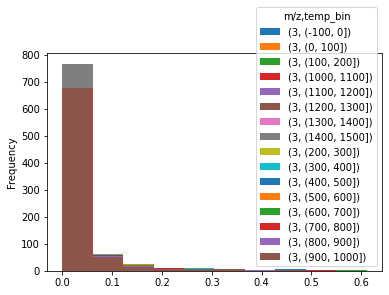

In [15]:
train_100[get_mz(3,train_100)].plot.hist()

<AxesSubplot:ylabel='Frequency'>

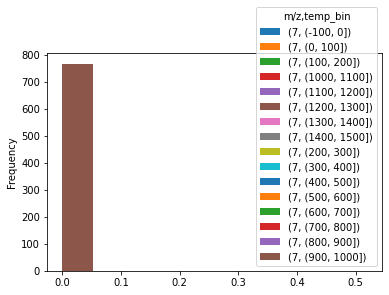

In [16]:
train_100[get_mz(7,train_100)].plot.hist()

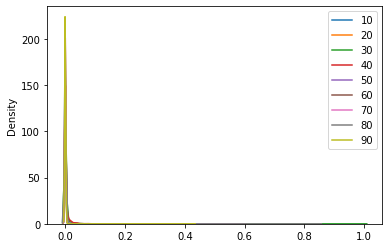

In [17]:
sns.kdeplot(train_100[get_mz(10,train_100)].values.flatten(),label='10')
sns.kdeplot(train_100[get_mz(20,train_100)].values.flatten(),label='20')
sns.kdeplot(train_100[get_mz(30,train_100)].values.flatten(),label='30')
sns.kdeplot(train_100[get_mz(40,train_100)].values.flatten(),label='40')
sns.kdeplot(train_100[get_mz(50,train_100)].values.flatten(),label='50')
sns.kdeplot(train_100[get_mz(60,train_100)].values.flatten(),label='60')
sns.kdeplot(train_100[get_mz(70,train_100)].values.flatten(),label='70')
sns.kdeplot(train_100[get_mz(80,train_100)].values.flatten(),label='80')
sns.kdeplot(train_100[get_mz(90,train_100)].values.flatten(),label='90')
plt.legend()

In [18]:
time_d = load('data/time_desc.joblib')
temp_d = load('data/temp_desc.joblib')
abund_d = load('data/abund_desc.joblib')
mz_d = load('data/mz_desc.joblib')
time_prog = load('data/time_prog.joblib') # what's this?

<AxesSubplot:xlabel='sample_id'>

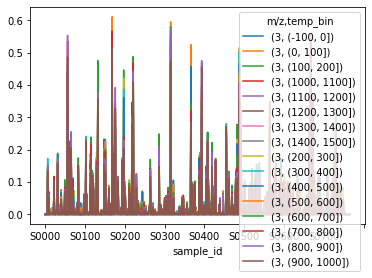

In [19]:
train_100[get_mz(3,train_100)].plot()

In [20]:
plt.rcParams['figure.figsize'] = (12,8)

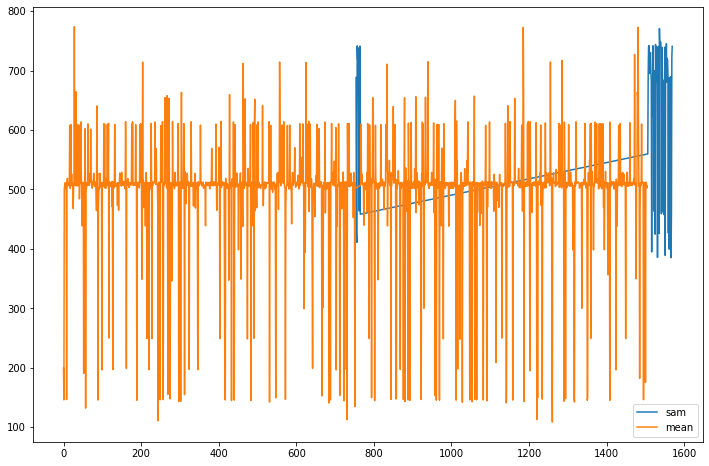

In [21]:
temp_d.loc[sam_idx,'mean'].plot(label='sam')
temp_d.loc[com_idx,'mean'].plot()
plt.legend()

<AxesSubplot:>

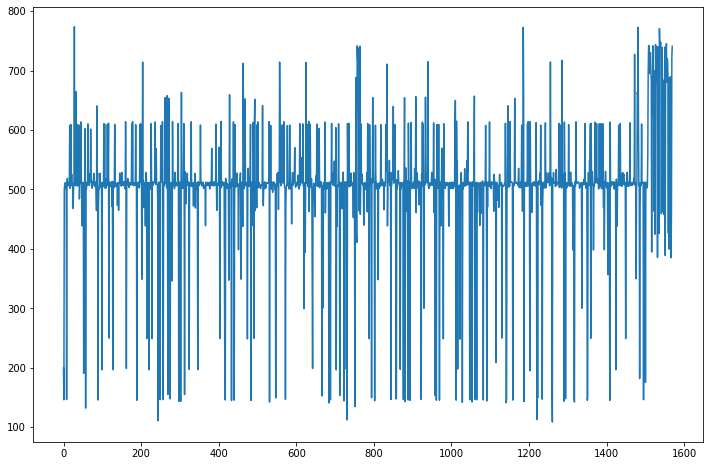

In [22]:
temp_d['mean'].plot()

In [23]:
temp_d.loc[sam_idx,'mean'].mean(), temp_d.loc[com_idx,'mean'].mean()

(636.0634203300514, 495.45362291511924)

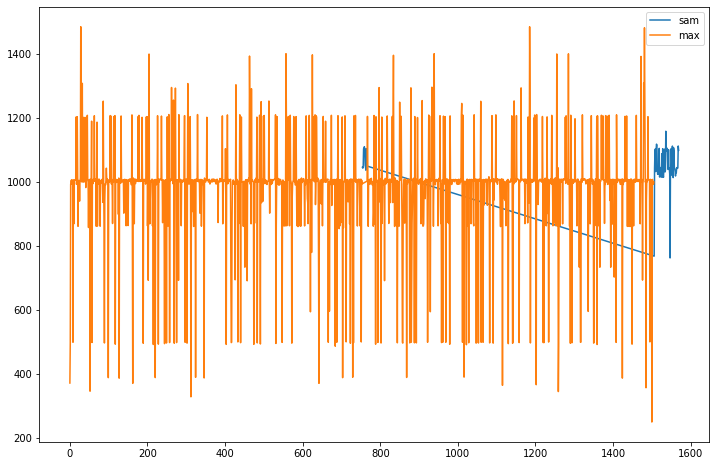

In [24]:
temp_d.loc[sam_idx,'max'].plot(label='sam')
temp_d.loc[com_idx,'max'].plot()
plt.legend()

In [25]:
temp_d.loc[sam_idx,'std'].mean(), temp_d.loc[com_idx,'std'].mean()

(347.8336739190716, 284.43536303827096)

In [26]:
train_100.index

Index(['S0000', 'S0001', 'S0002', 'S0003', 'S0004', 'S0005', 'S0006', 'S0007',
       'S0008', 'S0009',
       ...
       'S0756', 'S0757', 'S0758', 'S0759', 'S0760', 'S0761', 'S0762', 'S0763',
       'S0764', 'S0765'],
      dtype='object', name='sample_id', length=766)

<AxesSubplot:xlabel='sample_id'>

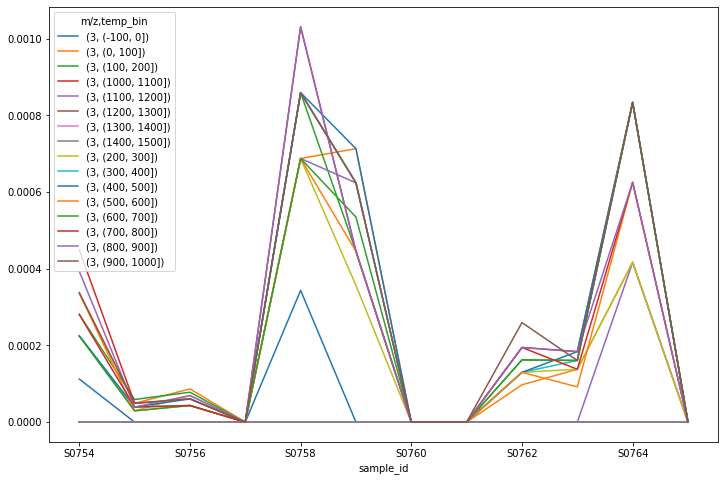

In [27]:
train_100.loc[sam_id[:12],get_mz(3,train_100)].plot()

<AxesSubplot:xlabel='sample_id'>

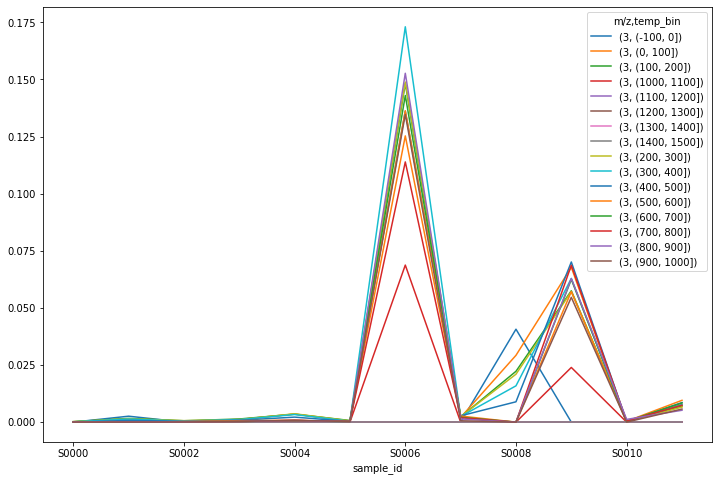

In [28]:
train_100.loc[com_id[:12],get_mz(3,train_100)].plot()

In [29]:
mz_d

,count,mean,std,min,25%,50%,75%,max
0,38600.0,99.5,57.735053,0.0,49.75,99.5,149.25,199.0
1,10020.0,30.5,17.318967,1.0,15.75,30.5,45.25,60.0
2,31900.0,49.5,28.866523,0.0,24.75,49.5,74.25,99.0
3,31900.0,49.5,28.866523,0.0,24.75,49.5,74.25,99.0
4,31900.0,49.5,28.866523,0.0,24.75,49.5,74.25,99.0
...,...,...,...,...,...,...,...,...
1565,120302.0,54.409536,30.426637,14.0,31.0,45.5,77.0,147.0
1566,151814.0,117.277847,80.285123,0.0,62.0,107.0,154.0,534.0
1567,188986.0,89.06092,50.556218,1.9,49.0,87.0,125.0,281.0
1568,126224.0,83.119961,49.354033,1.9,40.0,75.0,119.0,281.0


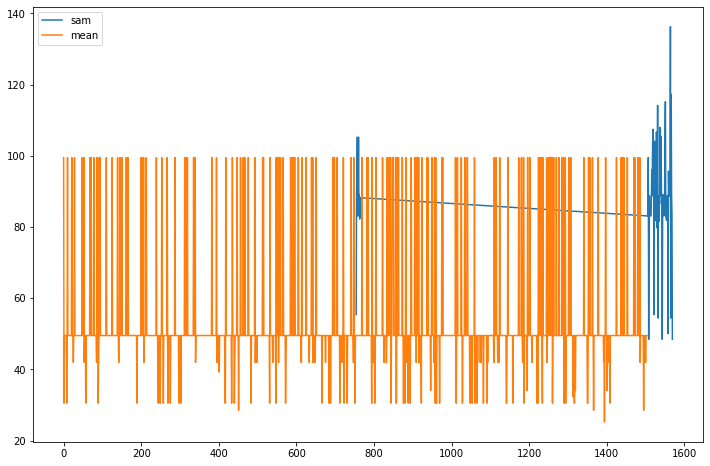

In [30]:
mz_d.loc[sam_idx,'mean'].plot(label='sam')
mz_d.loc[com_idx,'mean'].plot()
plt.legend()

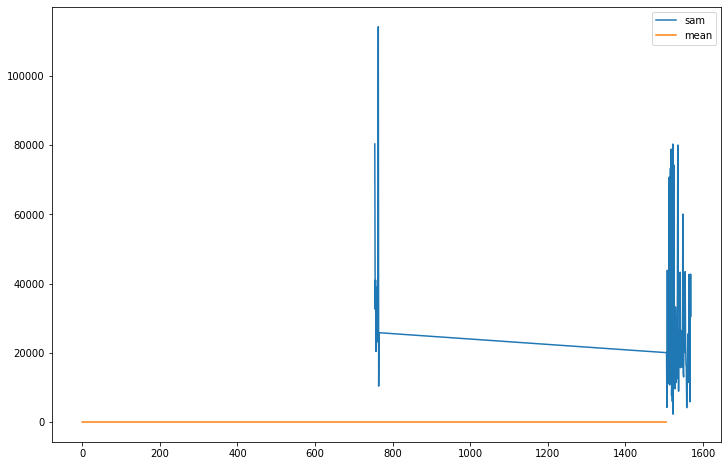

In [31]:
abund_d.loc[sam_idx,'mean'].plot(label='sam')
abund_d.loc[com_idx,'mean'].plot()
plt.legend()

In [32]:
abund_d.columns

Index(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], dtype='object')

In [33]:
abund_d['mean']

0                0.0
1                0.0
2                0.0
3                0.0
4                0.0
            ...     
1565    33929.863351
1566     5856.606979
1567    28270.152748
1568    42746.998249
1569    30612.095784
Name: mean, Length: 1570, dtype: object

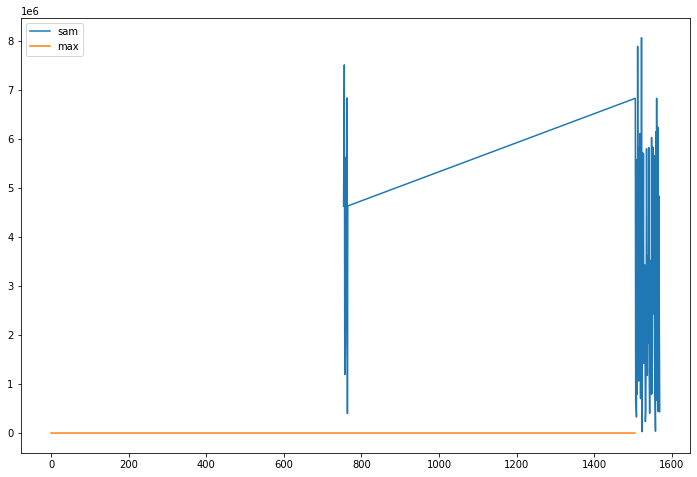

In [34]:
abund_d.loc[sam_idx,'max'].plot(label='sam')
abund_d.loc[com_idx,'max'].plot()
plt.legend()

<AxesSubplot:>

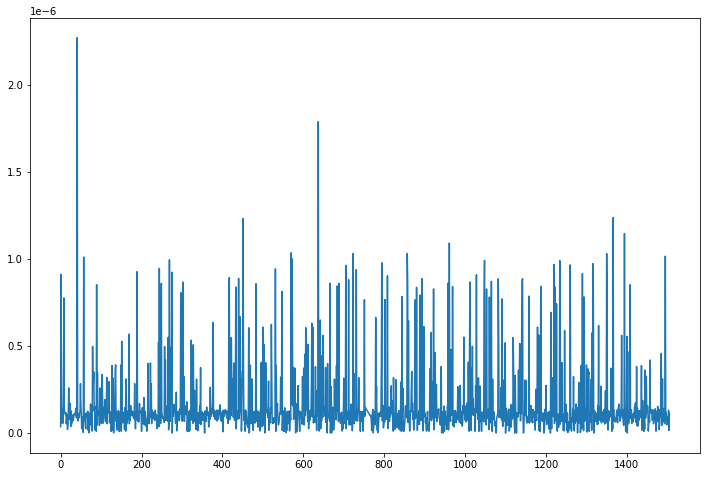

In [35]:
abund_d.loc[com_idx,'max'].plot()

In [36]:
train_100.loc[sam_id[:12],]

m/z               0                                                 \
temp_bin  (-100, 0]  (0, 100] (100, 200] (1000, 1100] (1100, 1200]   
sample_id                                                            
S0754           0.0  0.000000        0.0          0.0          0.0   
S0755           0.0  0.000000        0.0          0.0          0.0   
S0756           0.0  0.000043        0.0          0.0          0.0   
S0757           0.0  0.000000        0.0          0.0          0.0   
S0758           0.0  0.000000        0.0          0.0          0.0   
S0759           0.0  0.000000        0.0          0.0          0.0   
S0760           0.0  0.000000        0.0          0.0          0.0   
S0761           0.0  0.000000        0.0          0.0          0.0   
S0762           0.0  0.000000        0.0          0.0          0.0   
S0763           0.0  0.000000        0.0          0.0          0.0   
S0764           0.0  0.000000        0.0          0.0          0.0   
S0765           0.0  0.000000        0.0          0.0          0.0   

m/z                                                                     ...  \
temp_bin  (1200, 1300] (1300, 1400] (1400, 1500] (200, 300] (300, 400]  ...   
sample_id                                                               ...   
S0754              0.0          0.0          0.0        0.0        0.0  ...   
S0755              0.0          0.0          0.0        0.0        0.0  ...   
S0756              0.0          0.0          0.0        0.0        0.0  ...   
S0757              0.0          0.0          0.0        0.0        0.0  ...   
S0758              0.0          0.0          0.0        0.0        0.0  ...   
S0759              0.0          0.0          0.0        0.0        0.0  ...   
S0760              0.0          0.0          0.0        0.0        0.0  ...   
S0761              0.0          0.0          0.0        0.0        0.0  ...   
S0762              0.0          0.0          0.0        0.0        0.0  ...   
S0763              0.0          0.0          0.0        0.0        0.0  ...   
S0764              0.0          0.0          0.0        0.0        0.0  ...   
S0765              0.0          0.0          0.0        0.0        0.0  ...   

m/z                 99                                                \
temp_bin  (1300, 1400] (1400, 1500] (200, 300] (300, 400] (400, 500]   
sample_id                                                              
S0754              0.0          0.0   0.000337   0.000281   0.000337   
S0755              0.0          0.0   0.000059   0.000049   0.000049   
S0756              0.0          0.0   0.000095   0.000104   0.000104   
S0757              0.0          0.0   0.000705   0.000564   0.000282   
S0758              0.0          0.0   0.000688   0.000688   0.000688   
S0759              0.0          0.0   0.000713   0.000624   0.000535   
S0760              0.0          0.0   0.000143   0.000191   0.000095   
S0761              0.0          0.0   0.000086   0.000071   0.000071   
S0762              0.0          0.0   0.000195   0.000130   0.000260   
S0763              0.0          0.0   0.000184   0.000207   0.000184   
S0764              0.0          0.0   0.000417   0.000834   0.000834   
S0765              0.0          0.0   0.000069   0.000051   0.000086   

m/z                                                                
temp_bin  (500, 600] (600, 700] (700, 800] (800, 900] (900, 1000]  
sample_id                                                          
S0754       0.000337   0.000450   0.000337   0.000281    0.000450  
S0755       0.000049   0.000088   0.000049   0.000039    0.000049  
S0756       0.000113   0.000095   0.000069   0.000087    0.000121  
S0757       0.000705   0.000423   0.000282   0.000423    0.000423  
S0758       0.000859   0.000688   0.001031   0.000688    0.000859  
S0759       0.000535   0.000624   0.000624   0.000713    0.000713  
S0760       0.000191   0.000143   0.000143   0.000143    0.000143  
S0

In [37]:
targets.loc[sam_id[:12],].sum(axis=0)

basalt            0
carbonate         1
chloride          0
iron_oxide        0
oxalate           0
oxychlorine       1
phyllosilicate    1
silicate          0
sulfate           1
sulfide           0
dtype: int64

In [38]:
# first this mapping a
# next find right lr coefs..

In [59]:
def load_sample(n):
    if n < 1059:
        idx = metadata.loc[n,'sample_id']
        print(idx)
        df = pd.read_csv('data/train_features/'+idx+'.csv')
    else:
        idx = metadata.loc[n,'sample_id']
        print(idx)
        df = pd.read_csv('data/test_features/'+idx+'.csv')
    return df

In [40]:
s_2 = load_sample(2)
s_2

,time,temp,m/z,abundance
0,0.000,29.771,0.0,2.249971e-10
1,0.000,29.771,1.0,3.659241e-10
2,0.000,29.771,2.0,1.059353e-10
3,0.000,29.771,3.0,2.136264e-10
4,0.000,29.771,4.0,1.407858e-07
...,...,...,...,...
31895,1656.921,990.471,95.0,1.822786e-13
31896,1656.921,990.471,96.0,2.097095e-13
31897,1656.921,990.471,97.0,2.217361e-13
31898,1656.921,990.471,98.0,2.285130e-13


In [39]:
s_2.groupby('m/z').get_group(3)

,time,temp,m/z,abundance
3,0.000,29.771,3.0,2.136264e-10
103,5.196,29.774,3.0,2.127814e-10
203,10.403,29.849,3.0,2.135426e-10
303,15.605,30.169,3.0,2.156779e-10
403,20.807,30.660,3.0,2.121853e-10
...,...,...,...,...
31403,1636.089,978.262,3.0,1.829351e-10
31503,1641.282,981.304,3.0,1.882207e-10
31603,1646.499,984.385,3.0,1.885941e-10
31703,1651.732,987.447,3.0,1.868346e-10


In [40]:
s94 = load_sample(94)
s94

,time,temp,m/z,abundance
0,0.000,21.062,0.0,4.791683e-11
1,0.000,21.062,1.0,5.936770e-11
2,0.000,21.062,2.0,1.845503e-11
3,0.000,21.062,3.0,3.029323e-11
4,0.000,21.062,4.0,1.061280e-08
...,...,...,...,...
33995,1734.874,1041.950,195.0,6.566449e-14
33996,1734.874,1041.950,196.0,1.283708e-13
33997,1734.874,1041.950,197.0,9.547722e-14
33998,1734.874,1041.950,198.0,6.366803e-14


In [41]:
s94.groupby('m/z').get_group(3)

,time,temp,m/z,abundance
3,0.000,21.062,3.0,3.029323e-11
203,10.253,21.159,3.0,3.070520e-11
403,20.500,21.835,3.0,2.903599e-11
603,30.744,24.068,3.0,3.047636e-11
803,40.981,28.006,3.0,2.973164e-11
...,...,...,...,...
33003,1693.786,1017.834,3.0,4.184249e-11
33203,1704.057,1023.851,3.0,4.122751e-11
33403,1714.328,1029.864,3.0,4.185351e-11
33603,1724.592,1035.895,3.0,3.983575e-11


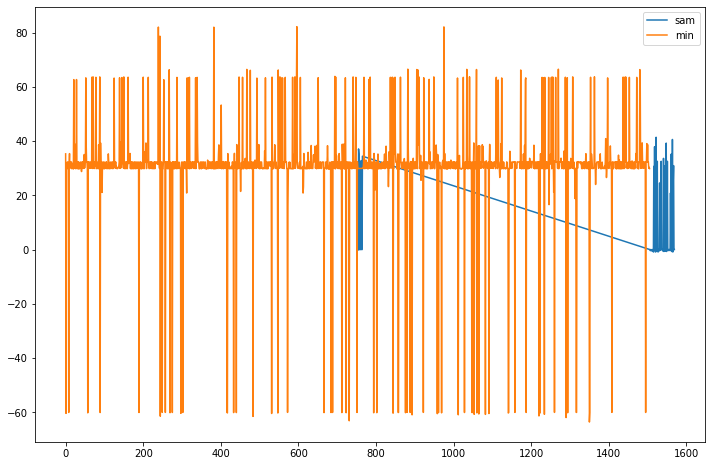

In [57]:
temp_d.loc[sam_idx,'min'].plot(label='sam')
temp_d.loc[com_idx,'min'].plot()
plt.legend()

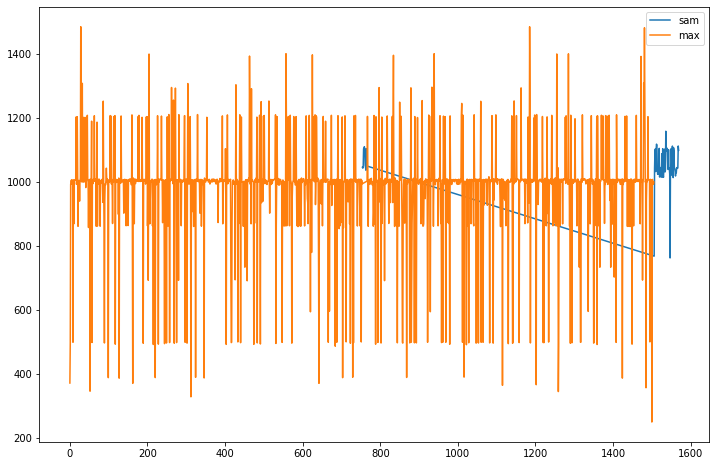

In [58]:
temp_d.loc[sam_idx,'max'].plot(label='sam')
temp_d.loc[com_idx,'max'].plot()
plt.legend()

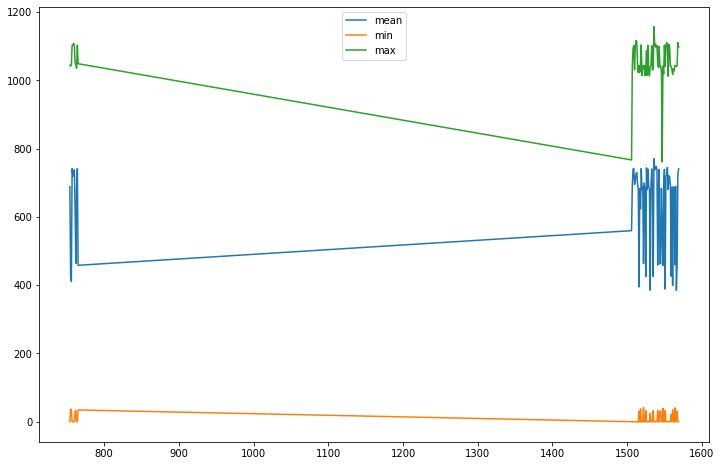

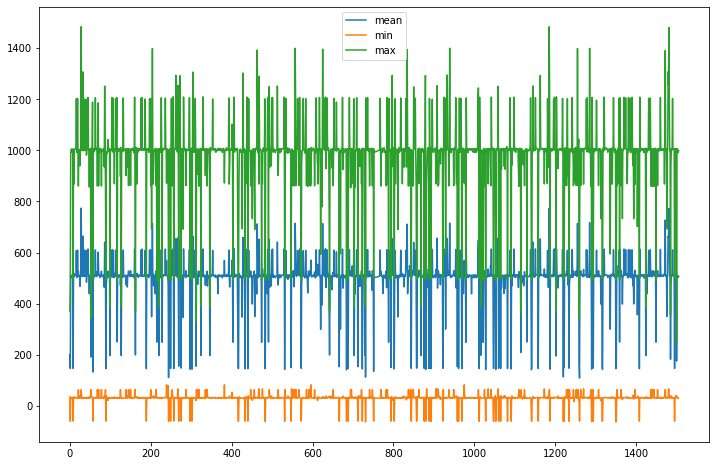

In [56]:
temp_d.loc[sam_idx,['mean','min','max']].plot(label='sam')
temp_d.loc[com_idx,['mean','min','max']].plot()
plt.legend()

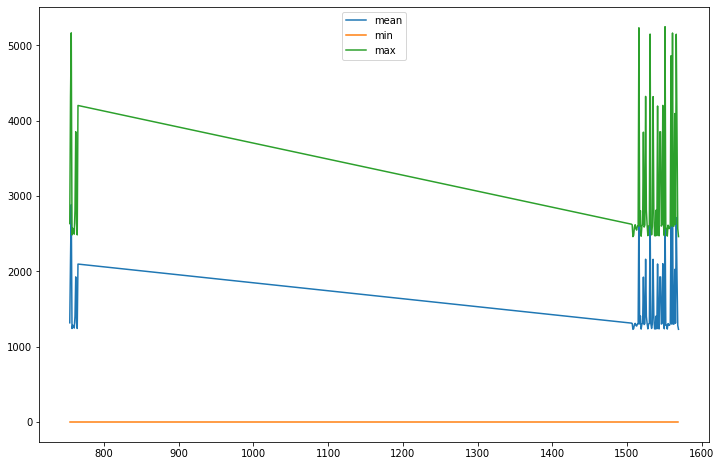

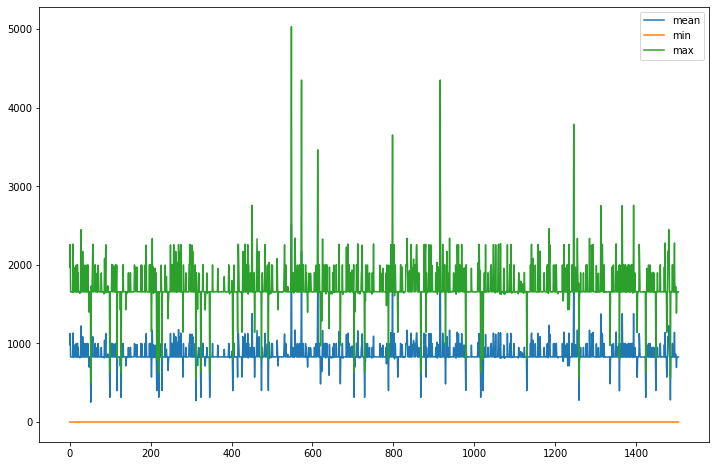

In [55]:
time_d.loc[sam_idx,['mean','min','max']].plot(label='sam')
time_d.loc[com_idx,['mean','min','max']].plot()
plt.legend()

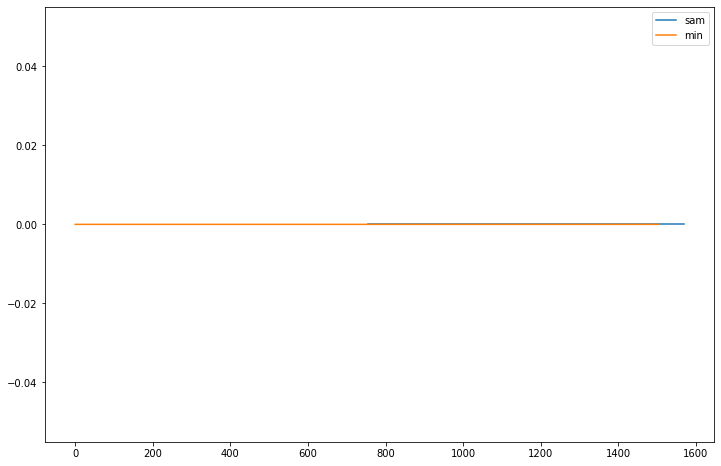

In [60]:
time_d.loc[sam_idx,'min'].plot(label='sam')
time_d.loc[com_idx,'min'].plot()
plt.legend()

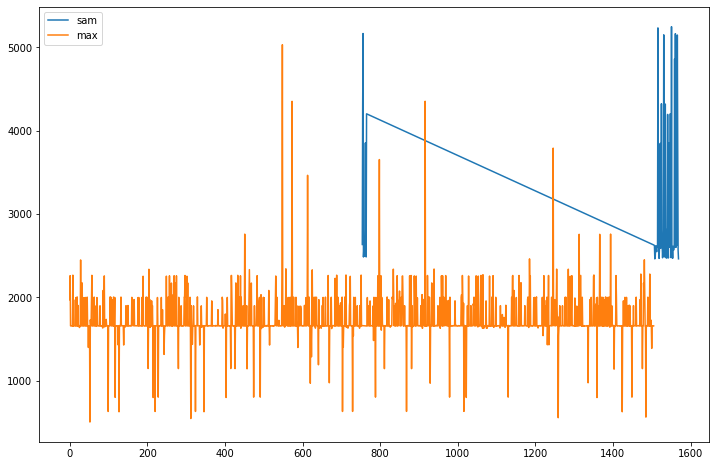

In [61]:
time_d.loc[sam_idx,'max'].plot(label='sam')
time_d.loc[com_idx,'max'].plot()
plt.legend()

In [65]:
display(time_d.loc[sam_idx,].describe())
display(time_d.loc[com_idx,].describe())

,count,mean,std,min,25%,50%,75%,max
count,76.0,76.000000,76.00000,76.0,76.00,76.00,76.00,76.00
unique,76.0,76.000000,76.00000,1.0,76.00,74.00,76.00,74.00
top,128917.0,1317.187173,760.48609,0.0,658.58,1309.67,1975.78,2604.82
freq,1.0,1.000000,1.00000,76.0,1.00,2.00,1.00,2.00


,count,mean,std,min,25%,50%,75%,max
count,1494.0,1494.00000,1494.000000,1494.0,1494.0,1494.0,1494.0,1494.0
unique,106.0,1494.00000,1494.000000,1.0,1318.0,1374.0,1398.0,1381.0
top,31900.0,985.59787,572.120885,0.0,563.0,1128.0,1711.0,2262.0
freq,621.0,1.00000,1.000000,1494.0,6.0,4.0,5.0,11.0


In [66]:
display(temp_d.loc[sam_idx,].describe())
display(temp_d.loc[com_idx,].describe())

,count,mean,std,min,25%,50%,75%,max
count,76.0,76.000000,76.000000,76.0,76.000,76.000,76.000,76.000
unique,76.0,76.000000,76.000000,27.0,72.000,72.000,74.000,68.000
top,128917.0,688.363178,351.886793,0.0,120.689,310.583,842.269,1041.142
freq,1.0,1.000000,1.000000,30.0,3.000,3.000,2.000,4.000


,count,mean,std,min,25%,50%,75%,max
count,1494.0,1494.00000,1494.000000,1494.000,1494.000,1494.000,1494.000,1494.000
unique,106.0,1494.00000,1494.000000,809.000,1443.000,1448.000,1465.000,1435.000
top,31900.0,199.44213,99.268459,32.291,-59.999,513.979,758.253,1005.564
freq,621.0,1.00000,1.000000,9.000,4.000,3.000,2.000,3.000


In [67]:
display(mz_d.loc[sam_idx,].describe())
display(mz_d.loc[com_idx,].describe())

,count,mean,std,min,25%,50%,75%,max
count,76.0,76.000000,76.000000,76.0,76.0,76.0,76.0,76.0
unique,76.0,76.000000,76.000000,6.0,27.0,29.0,26.0,8.0
top,128917.0,55.372867,28.644775,1.9,48.0,87.0,125.0,281.0
freq,1.0,1.000000,1.000000,43.0,17.0,14.0,23.0,40.0


,count,mean,std,min,25%,50%,75%,max
count,1494.0,1494.0,1494.000000,1494.0,1494.00,1494.0,1494.00,1494.0
unique,106.0,13.0,108.000000,4.0,7.00,9.0,10.00,7.0
top,31900.0,49.5,28.866523,0.0,24.75,49.5,74.25,99.0
freq,621.0,1211.0,621.000000,1372.0,1239.00,1211.0,1211.00,1211.0


In [68]:
display(abund_d.loc[sam_idx,].describe())
display(abund_d.loc[com_idx,].describe())

,count,mean,std,min,25%,50%,75%,max
count,76.0,76.000000,76.000000,76.0,76.0,76.0,76.0,76.0
unique,76.0,76.000000,76.000000,1.0,10.0,25.0,53.0,76.0
top,128917.0,80347.106488,440859.901092,0.0,0.0,176.5,1058.8,4627882.4
freq,1.0,1.000000,1.000000,76.0,37.0,9.0,4.0,1.0


,count,mean,std,min,25%,50%,75%,max
count,1494.0,1.494000e+03,1.494000e+03,1.494000e+03,1.494000e+03,1.494000e+03,1.494000e+03,1494.000000
unique,106.0,1.494000e+03,1.494000e+03,1.475000e+03,1.467000e+03,1.489000e+03,1.490000e+03,1481.000000
top,31900.0,1.297623e-10,1.277154e-09,1.165848e-13,1.060000e-12,3.520000e-12,3.090000e-11,0.000001
freq,621.0,1.000000e+00,1.000000e+00,2.000000e+00,6.000000e+00,2.000000e+00,2.000000e+00,3.000000


In [41]:
load_sample(1)

,time,temp,m/z,abundance
0,0.0,-60.370,1.0,2.620000e-10
1,0.0,-60.370,2.0,4.200000e-08
2,0.0,-60.370,3.0,3.690000e-09
3,0.0,-60.370,4.0,9.080000e-07
4,0.0,-60.370,5.0,1.120000e-11
...,...,...,...,...
10015,2260.0,497.404,56.0,1.030000e-12
10016,2260.0,497.404,57.0,7.010000e-13
10017,2260.0,497.404,58.0,7.330000e-13
10018,2260.0,497.404,59.0,-5.560000e-14


754    S0754
755    S0755
756    S0756
757    S0757
758    S0758
759    S0759
760    S0760
761    S0761
762    S0762
763    S0763
764    S0764
765    S0765
Name: sample_id, dtype: object

<AxesSubplot:>

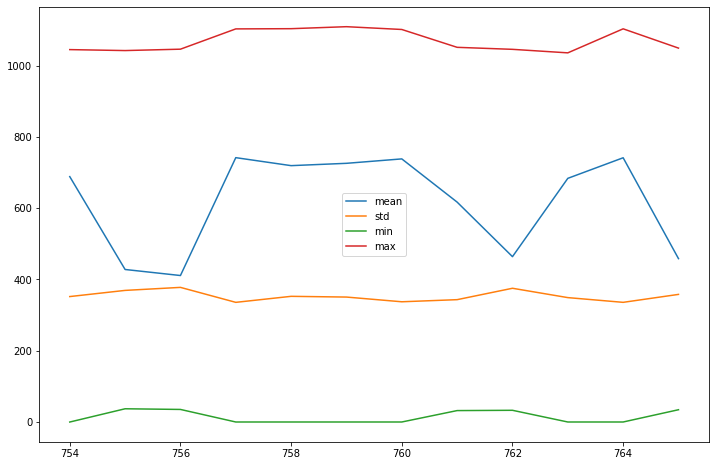

In [52]:
temp_d.loc[sam_idx[:12],][['mean','std','min','max']].plot()

<AxesSubplot:>

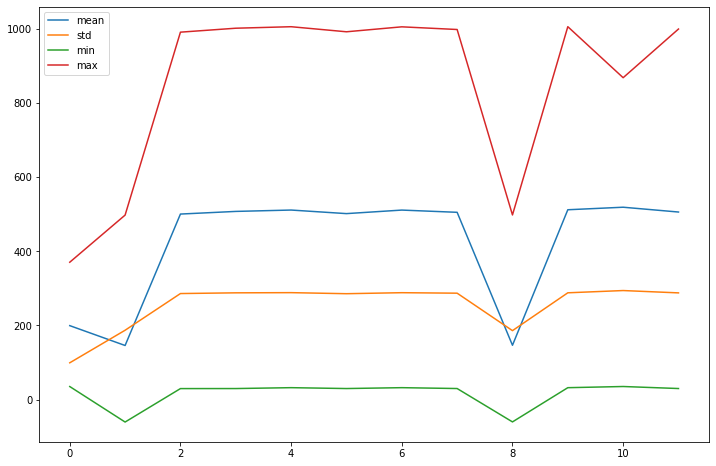

In [53]:
temp_d.loc[com_idx[:12],][['mean','std','min','max']].plot()

In [45]:
s765 = load_sample(765)
s765

,time,temp,m/z,abundance
0,0.00,35.763,0.0,58.8
1,0.20,34.959,5.0,0.0
2,0.22,35.495,6.0,58.8
3,0.24,34.959,7.0,0.0
4,0.42,35.763,12.0,40117.6
...,...,...,...,...
141308,4202.48,1046.333,69.0,2588.2
141309,4202.50,1046.333,70.0,294.1
141310,4202.52,1047.632,71.0,0.0
141311,4202.54,1047.199,72.0,588.2


In [46]:
s765[s765['m/z'] < 100]

,time,temp,m/z,abundance
0,0.00,35.763,0.0,58.8
1,0.20,34.959,5.0,0.0
2,0.22,35.495,6.0,58.8
3,0.24,34.959,7.0,0.0
4,0.42,35.763,12.0,40117.6
...,...,...,...,...
141308,4202.48,1046.333,69.0,2588.2
141309,4202.50,1046.333,70.0,294.1
141310,4202.52,1047.632,71.0,0.0
141311,4202.54,1047.199,72.0,588.2


<AxesSubplot:>

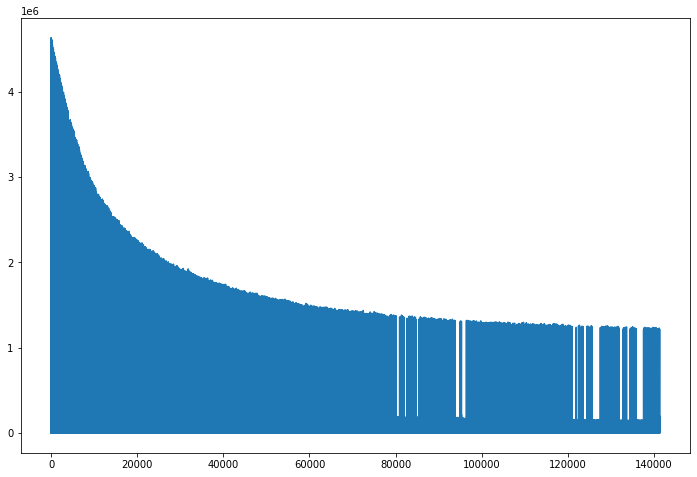

In [61]:
s765[s765['m/z'] < 100]['abundance'].plot()

<AxesSubplot:>

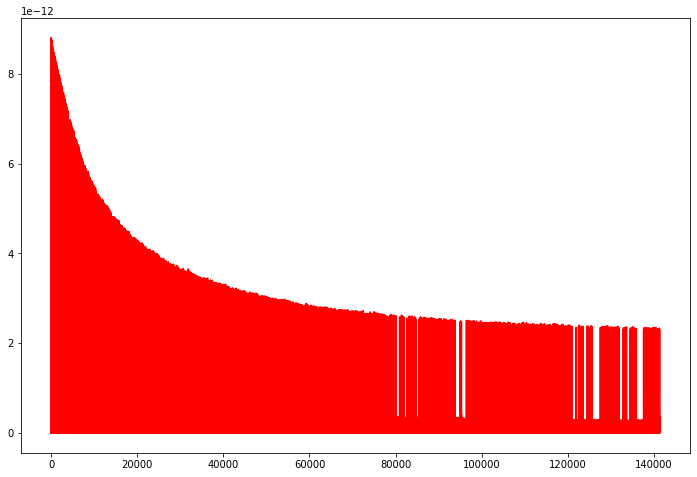

In [75]:
conv_s765 = s765[s765['m/z'] < 100]['abundance']* 1.9*10e-19
conv_s765.plot(C='r')

In [64]:
conv_s765.describe()

count    1.164220e+05
mean     5.950072e-14
std      3.533554e-13
min      0.000000e+00
25%      4.470700e-16
50%      2.011720e-15
75%      1.151172e-14
max      8.802141e-12
Name: abundance, dtype: float64

<AxesSubplot:>

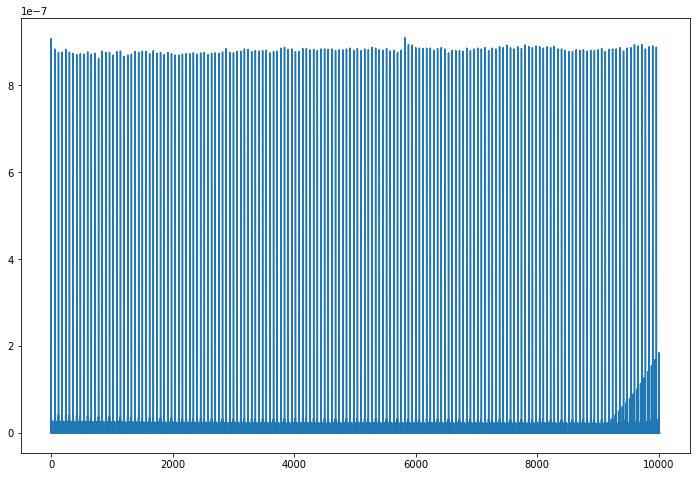

In [70]:
s1['abundance'].plot()

<AxesSubplot:>

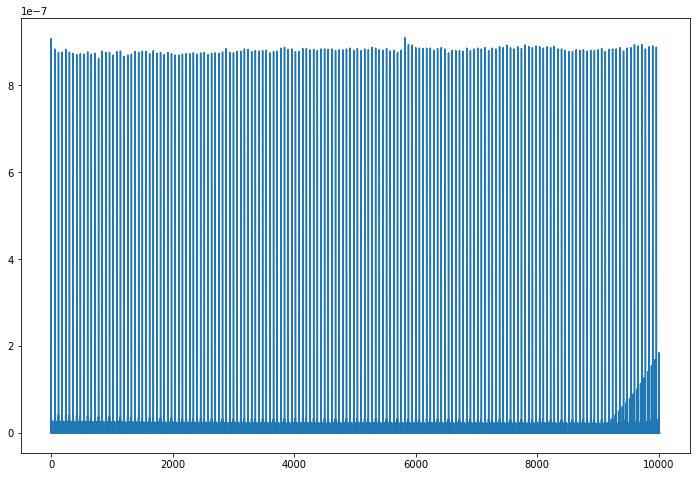

In [63]:
s1 = load_sample(1)
s1['abundance'].plot()

In [47]:
[1,2,3,4]
#  these are really tough to deal with....

[1, 2, 3, 4]

In [48]:
mz1 = get_mz(1,train_100)

In [71]:
mz5 = get_mz(5,train_100)

<AxesSubplot:xlabel='sample_id'>

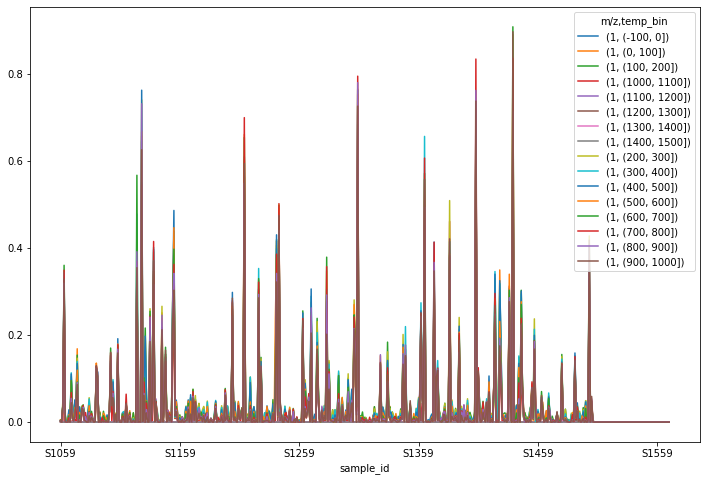

In [49]:
test_100[mz1].plot()

In [50]:
test_100[mz1].tail(12)

m/z               1                                                \
temp_bin  (-100, 0] (0, 100] (100, 200] (1000, 1100] (1100, 1200]   
sample_id                                                           
S1558           0.0      0.0        0.0          0.0          0.0   
S1559           0.0      0.0        0.0          0.0          0.0   
S1560           0.0      0.0        0.0          0.0          0.0   
S1561           0.0      0.0        0.0          0.0          0.0   
S1562           0.0      0.0        0.0          0.0          0.0   
S1563           0.0      0.0        0.0          0.0          0.0   
S1564           0.0      0.0        0.0          0.0          0.0   
S1565           0.0      0.0        0.0          0.0          0.0   
S1566           0.0      0.0        0.0          0.0          0.0   
S1567           0.0      0.0        0.0          0.0          0.0   
S1568           0.0      0.0        0.0          0.0          0.0   
S1569           0.0      0.0        0.0          0.0          0.0   

m/z                                                                     \
temp_bin  (1200, 1300] (1300, 1400] (1400, 1500] (200, 300] (300, 400]   
sample_id                                                                
S1558              0.0          0.0          0.0        0.0        0.0   
S1559              0.0          0.0          0.0        0.0        0.0   
S1560              0.0          0.0          0.0        0.0        0.0   
S1561              0.0          0.0          0.0        0.0        0.0   
S1562              0.0          0.0          0.0        0.0        0.0   
S1563              0.0          0.0          0.0        0.0        0.0   
S1564              0.0          0.0          0.0        0.0        0.0   
S1565              0.0          0.0          0.0        0.0        0.0   
S1566              0.0          0.0          0.0        0.0        0.0   
S1567              0.0          0.0          0.0        0.0        0.0   
S1568              0.0          0.0          0.0        0.0        0.0   
S1569              0.0          0.0          0.0        0.0        0.0   

m/z                                                                           
temp_bin  (400, 500] (500, 600] (600, 700] (700, 800] (800, 900] (900, 1000]  
sample_id                                                                     
S1558            0.0        0.0        0.0        0.0        0.0         0.0  
S1559            0.0        0.0        0.0        0.0        0.0         0.0  
S1560            0.0        0.0        0.0        0.0        0.0         0.0  
S1561            0.0        0.0        0.0        0.0        0.0         0.0  
S1562            0.0        0.0        0.0        0.0        0.0         0.0  
S1563            0.0        0.0        0.0        0.0        0.0         0.0  
S1564            0.0        0.0        0.0        0.0        0.0         0.0  
S1565            0.0        0.0        0.0        0.0        0.0         0.0  
S1566            0.0        0.0        0.0        0.0        0.0         0.0  
S1567            0.0        0.0        0.0        0.0        0.0         0.0  
S1568            0.0        0.0        0.0        0.0        0.0         0.0  
S1569            0.0        0.0        0.0        0.0        0.0         0.0

<AxesSubplot:xlabel='sample_id'>

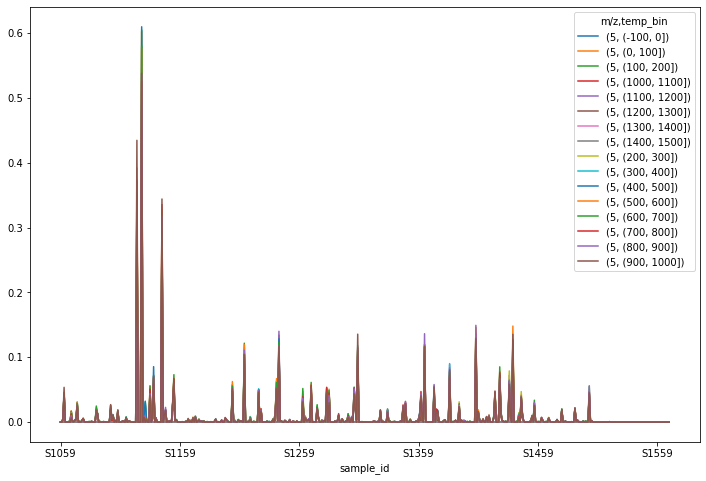

In [73]:
test_100[mz5].plot()

<AxesSubplot:xlabel='sample_id'>

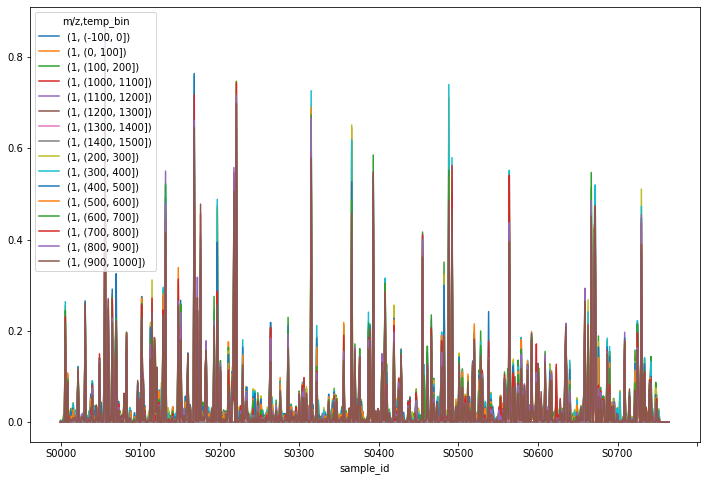

In [51]:
train_100[mz1].plot()

In [53]:
train_100[mz1].tail(12)* 1.9*10e-19

m/z               1                                                \
temp_bin  (-100, 0] (0, 100] (100, 200] (1000, 1100] (1100, 1200]   
sample_id                                                           
S0754           0.0      0.0        0.0          0.0          0.0   
S0755           0.0      0.0        0.0          0.0          0.0   
S0756           0.0      0.0        0.0          0.0          0.0   
S0757           0.0      0.0        0.0          0.0          0.0   
S0758           0.0      0.0        0.0          0.0          0.0   
S0759           0.0      0.0        0.0          0.0          0.0   
S0760           0.0      0.0        0.0          0.0          0.0   
S0761           0.0      0.0        0.0          0.0          0.0   
S0762           0.0      0.0        0.0          0.0          0.0   
S0763           0.0      0.0        0.0          0.0          0.0   
S0764           0.0      0.0        0.0          0.0          0.0   
S0765           0.0      0.0        0.0          0.0          0.0   

m/z                                                                     \
temp_bin  (1200, 1300] (1300, 1400] (1400, 1500] (200, 300] (300, 400]   
sample_id                                                                
S0754              0.0          0.0          0.0        0.0        0.0   
S0755              0.0          0.0          0.0        0.0        0.0   
S0756              0.0          0.0          0.0        0.0        0.0   
S0757              0.0          0.0          0.0        0.0        0.0   
S0758              0.0          0.0          0.0        0.0        0.0   
S0759              0.0          0.0          0.0        0.0        0.0   
S0760              0.0          0.0          0.0        0.0        0.0   
S0761              0.0          0.0          0.0        0.0        0.0   
S0762              0.0          0.0          0.0        0.0        0.0   
S0763              0.0          0.0          0.0        0.0        0.0   
S0764              0.0          0.0          0.0        0.0        0.0   
S0765              0.0          0.0          0.0        0.0        0.0   

m/z                                                                           
temp_bin  (400, 500] (500, 600] (600, 700] (700, 800] (800, 900] (900, 1000]  
sample_id                                                                     
S0754            0.0        0.0        0.0        0.0        0.0         0.0  
S0755            0.0        0.0        0.0        0.0        0.0         0.0  
S0756            0.0        0.0        0.0        0.0        0.0         0.0  
S0757            0.0        0.0        0.0        0.0        0.0         0.0  
S0758            0.0        0.0        0.0        0.0        0.0         0.0  
S0759            0.0        0.0        0.0        0.0        0.0         0.0  
S0760            0.0        0.0        0.0        0.0        0.0         0.0  
S0761            0.0        0.0        0.0        0.0        0.0         0.0  
S0762            0.0        0.0        0.0        0.0        0.0         0.0  
S0763            0.0        0.0        0.0        0.0        0.0         0.0  
S0764            0.0        0.0        0.0        0.0        0.0         0.0  
S0765            0.0        0.0        0.0        0.0        0.0         0.0

In [76]:
#  how to scale??
#  1.9 x 10-19 or 1.602×10-19 ?

In [81]:
train_set_50.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1059 entries, 0 to 1058
Columns: 4200 entries, ('0', '(-100, -50]') to ('99', '(950, 1000]')
dtypes: float64(4200)
memory usage: 33.9 MB


In [84]:
import feature_engine as fe
import featuretools as ft

In [119]:
train_set_50.columns = [str(x) for x in range(train_set_50.shape[1]) ]
train_set_100.columns = [str(x) for x in range(train_set_100.shape[1]) ]

In [127]:
train_set_50.index = train_idx.append(val_idx)
train_set_100.index = train_id.append(val_id)

In [128]:
es_50 = ft.EntitySet(id='df')
es_50.add_dataframe(train_set_100, 'train_set_100',index='sample_id')

Entityset: df
  DataFrames:
    train_set_100 [Rows: 1059, Columns: 1601]
  Relationships:
    No relationships

In [ ]:
# es_50.normalize_dataframe(base_dataframe_name='train_set_100',new_dataframe_name='new_df',new_index=)

In [138]:
prims = ft.list_primitives()
prims

,name,type,dask_compatible,koalas_compatible,description,valid_inputs,return_type
0,trend,aggregation,False,False,Calculates the trend of a column over time.,<ColumnSchema (Logical Type = Datetime) (Seman...,None
1,entropy,aggregation,False,False,Calculates the entropy for a categorical column,<ColumnSchema (Semantic Tags = ['category'])>,None
2,median,aggregation,False,False,Determines the middlemost number in a list of ...,<ColumnSchema (Semantic Tags = ['numeric'])>,None
3,skew,aggregation,False,False,Computes the extent to which a distribution di...,<ColumnSchema (Semantic Tags = ['numeric'])>,None
4,n_most_common,aggregation,False,False,Determines the `n` most common elements.,<ColumnSchema (Semantic Tags = ['category'])>,None
...,...,...,...,...,...,...,...
108,cum_max,transform,False,False,Calculates the cumulative maximum.,<ColumnSchema (Semantic Tags = ['numeric'])>,None
109,rolling_max,transform,False,False,Determines the maximum of entries over a given...,<ColumnSchema (Logical Type = Datetime) (Seman...,None
110,stopword_count,transform,False,False,Determines number of stopwords in a string.,<ColumnSchema (Logical Type = NaturalLanguage)>,None
111,lsa,transform,False,False,Calculates the Latent Semantic Analysis Values...,<ColumnSchema (Logical Type = NaturalLanguage)>,None


In [156]:
ft_mtrx, ft_names = ft.dfs(
    entityset = es_50,
    target_dataframe_name='train_set_100',
    agg_primitives=["mean", "sum", "mode"],
    trans_primitives = ['add_numeric', 'multiply_numeric'],
    max_depth=2,
    verbose=True
)

In [152]:
ft_mtrx

,0,1,2,3,4,5,6,7,8,9,...,1590,1591,1592,1593,1594,1595,1596,1597,1598,1599
sample_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.004085,0.004641,0.000000,0.0,0.0,0.0,0.0,0.001394,0.000188,...,0.0,0.0,2.898509e-06,0.000003,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
1,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
2,0.0,0.002270,0.002495,0.000000,0.0,0.0,0.0,0.0,0.001688,0.000636,...,0.0,0.0,9.257968e-07,0.000001,0.000001,0.000001,9.397170e-07,0.000001,0.000001,0.000001
3,0.0,0.001336,0.002464,0.000306,0.0,0.0,0.0,0.0,0.001099,0.000992,...,0.0,0.0,4.379099e-06,0.000006,0.000005,0.000005,4.693477e-06,0.000004,0.000004,0.000004
4,0.0,0.005993,0.012429,0.000593,0.0,0.0,0.0,0.0,0.009380,0.005099,...,0.0,0.0,3.904920e-06,0.000004,0.000004,0.000005,3.174421e-06,0.000004,0.000004,0.000003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1054,0.0,0.129083,0.131998,0.096385,0.0,0.0,0.0,0.0,0.157281,0.156331,...,0.0,0.0,3.437657e-04,0.000236,0.000353,0.000350,2.672030e-04,0.000363,0.000355,0.000282
1055,0.0,0.037724,0.036757,0.020977,0.0,0.0,0.0,0.0,0.042467,0.046966,...,0.0,0.0,1.277169e-04,0.000127,0.000225,0.000165,2.020603e-04,0.000148,0.000145,0.000142
1056,0.0,0.000371,0.001633,0.000016,0.0,0.0,0.0,0.0,0.000520,0.000234,...,0.0,0.0,2.138303e-06,0.000003,0.000003,0.000003,2.037079e-06,0.000003,0.000002,0.000002
